In [1]:
!pip install -q -U bitsandbytes peft accelerate evaluate

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm 
from datasets import load_dataset,Dataset
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from transformers import TrainingArguments,Trainer,DataCollatorWithPadding
from transformers import BitsAndBytesConfig
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import os

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [44]:
df = pd.read_csv('/kaggle/input/multi-lingual-sentiment-analysis/train.csv')
train = {"train":"/kaggle/input/multi-lingual-sentiment-analysis/train.csv"}
test = {"test":"/kaggle/input/multi-lingual-sentiment-analysis/test.csv"}
ds = load_dataset("csv",data_files=train,split="train")
ds_test = load_dataset("csv",data_files=test,split="test")
dataset = ds.map(lambda e: {"text": e["sentence"], "label": e["label"]}, remove_columns=["ID","sentence","label"])
dataset_test = ds_test.map(lambda e: {"text": e["sentence"],"label":""}, remove_columns=["ID","sentence"])

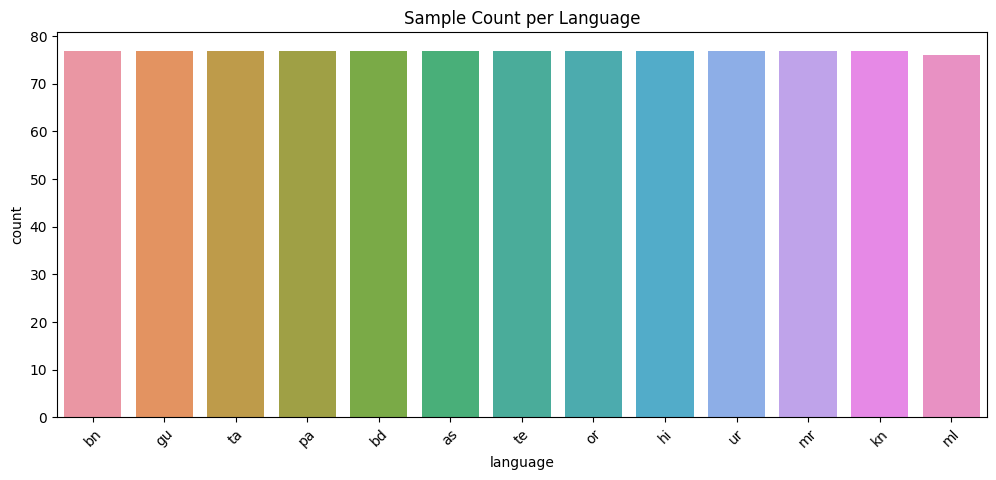

In [45]:
plt.figure(figsize=(12,5))
sns.countplot(x='language',
             data=df,
             order=df['language'].value_counts().index)
plt.title('Sample Count per Language')
plt.xticks(rotation=45)
plt.show()


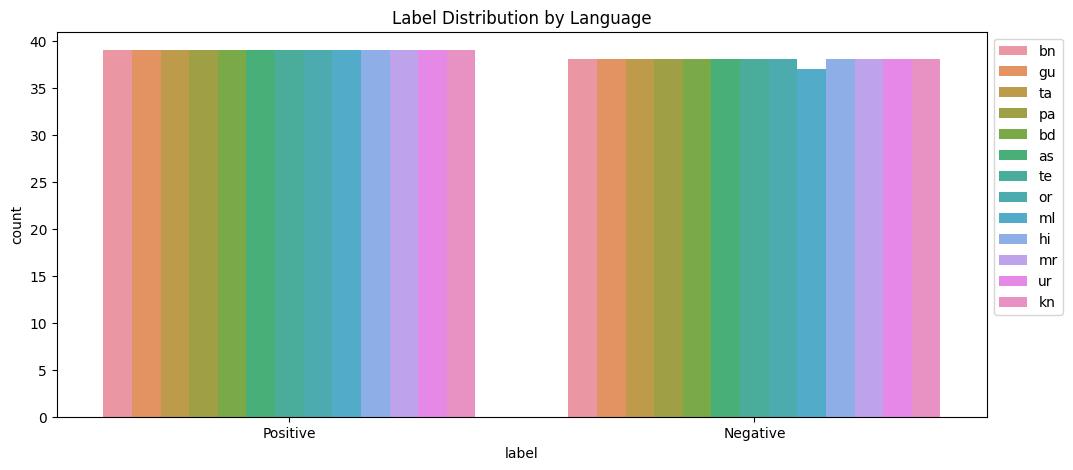

In [46]:
plt.figure(figsize=(12,5))
sns.countplot(x='label',
             hue='language',
             data=df)
plt.title('Label Distribution by Language')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

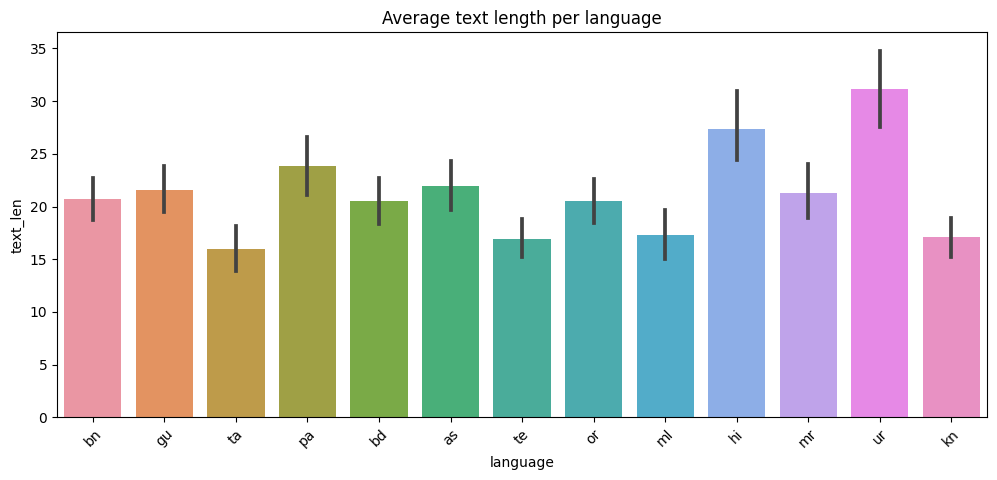

In [47]:
df['text_len'] = df['sentence'].apply(lambda x : len(str(x).split()))
plt.figure(figsize=(12,5))
sns.barplot(x='language',
           y='text_len',
           data=df)

plt.title("Average text length per language")
plt.xticks(rotation=45)
plt.show()

In [6]:
quant_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_compute_dtype=torch.float16
)

In [7]:
model_id = '/kaggle/input/llama-3.1/transformers/8b-instruct/2'
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
)
tokenizer.pad_token = tokenizer.eos_token

In [8]:

def label_it(example):
    if example["label"] == "Negative":
        example["label"] = 0
    if example["label"] == "Positive":
        example["label"] = 1
    return example

dataset = dataset.map(label_it)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [12]:
def tokenize(example):
    example = tokenizer(example['text'],
                       padding=False,
                       truncation=True)
    return example

In [14]:
tokenized_ds = dataset.map(tokenize,
                          batched=True,
                          num_proc=12,
                          remove_columns=['text','language'])
print(tokenized_ds)

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 1000
})


In [15]:
split_ds = tokenized_ds.train_test_split(test_size=0.1,
                                        seed=42)
print(split_ds)

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 900
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
})


In [16]:
split_ds = split_ds.rename_column('label','labels')

In [18]:
data_collator = DataCollatorWithPadding(tokenizer,padding=True)

In [19]:
from peft import LoraConfig,LoraModel,TaskType
lora_config = LoraConfig(
    r=8,
    target_modules=['q_proj','v_proj'],
    task_type = TaskType.CAUSAL_LM,
    inference_mode=False,
    lora_alpha=32,
    lora_dropout=0.05
)

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=2,
    pad_token_id = tokenizer.eos_token_id,
    quantization_config=quant_config
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/llama-3.1/transformers/8b-instruct/2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model = model.to(device)

In [22]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128009)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_lay

In [23]:
from peft import get_peft_model
lora_model = get_peft_model(model,lora_config)
lora_model.print_trainable_parameters()
print(lora_model)

trainable params: 3,407,872 || all params: 7,508,340,736 || trainable%: 0.0454
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128009)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B)

In [24]:
sum(p.numel() for p in lora_model.parameters() if p.requires_grad)

3407872

In [25]:
import evaluate
metric = evaluate.load('f1')

In [26]:
def compute_metrics(eval_pred):
    logits,labels = eval_pred
    predictions = np.argmax(logits,axis=-1)
    return metric.compute(predictions=predictions,
                         references=labels,
                         average='macro')

In [27]:
training_args = TrainingArguments(
    output_dir = 'llama3_ft_lora',
    eval_strategy = 'steps',
    num_train_epochs = 1,
    max_steps = 1000,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    bf16 = False,
    fp16 = True,
    tf32 = False,
    gradient_accumulation_steps = 4,
    adam_beta1 = 0.9,
    adam_beta2 = 0.999,
    learning_rate = 2e-5,
    weight_decay = 0.01,
    logging_dir = 'logs',
    logging_strategy = 'steps',
    logging_steps = 100,
    save_steps = 500,
    save_total_limit = 20,
    report_to = 'none'
)

In [29]:
trainer = Trainer(
    model = lora_model,
    args = training_args,
    train_dataset = split_ds['train'],
    eval_dataset = split_ds['test'],
    compute_metrics = compute_metrics,
    data_collator = data_collator
)

In [30]:
results = trainer.train()

Step,Training Loss,Validation Loss,F1
100,1.121600,0.969531,0.507587
200,0.741500,0.598079,0.689969
300,0.380700,0.339766,0.868938
400,0.291500,0.301007,0.899840
500,0.278000,0.460312,0.889901
600,0.228400,0.542594,0.919872
700,0.254100,0.530777,0.909265
800,0.189600,0.527018,0.919872
900,0.137900,0.537246,0.919711
1000,0.137500,0.538847,0.919711


In [48]:
from transformers import TextClassificationPipeline
classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    framework='pt',
    task='sentiment-analysis',
)
model.config.id2label = {0:'Negative',1:'Positive'}

Device set to use cuda:0


In [49]:
ds_test

Dataset({
    features: ['ID', 'sentence', 'language'],
    num_rows: 100
})

In [36]:
def pred(example):
    text = example['sentence']
    prediction = classifier(text)
    example['label'] = prediction[0]['label']
    return example

ds_test=ds_test.map(pred)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [37]:
sub = {"ID":ds_test['ID'],"label":ds_test['label']}
sub = pd.DataFrame(sub)
sub.head()

,ID,label
0,1,Positive
1,2,Positive
2,3,Positive
3,4,Positive
4,5,Negative


In [38]:
sub.to_csv('submission.csv',index=False)

In [40]:
trainer.save_model('./model')
tokenizer.save_pretrained('./model')

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/tokenizer.json')

In [43]:
ds_test

Dataset({
    features: ['ID', 'sentence', 'language', 'label'],
    num_rows: 100
})

In [52]:
predictions = []
for example in tqdm(ds_test):
    text = example['sentence']
    lang = example.get('language','unknown')
    result = classifier(text)[0]
    predictions.append({
        "text":text,
        "pred_label":result['label'],
        "confidence":result['score'],
        'language':lang
    })
df_pred = pd.DataFrame(predictions)
df_pred.head()

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


,text,pred_label,confidence,language
0,"1120 mAh, ਓਵਰਚਾਰਜਿੰਗ ਦੀ ਸੁਰੱਖਿਆ",Positive,0.960039,pa
1,તે સઘન મોઇશ્ચરાઇઝિંગ પ્રદાન કરે છે અને સરસ સ્વ...,Positive,1.000000,gu
2,"1120 ಎಂಎಎಚ್, ಮಿತಿಮೀರಿದ ರಕ್ಷಣೆ",Positive,0.742865,kn
3,ভাৰতত নিৰ্মিত সৰ্বশ্ৰেষ্ঠ পাৰফিউম ব্ৰেণ্ডবোৰৰ ...,Positive,1.000000,as
4,"میں نے حال ہی میں ""انفولڈ"" سے ایک ٹیمپلیٹ خرید...",Negative,0.999992,ur


In [53]:
lang_summary = (
    df_pred.groupby('language')
    .agg({
        "pred_label":lambda x:x.value_counts().to_dict(),
        "confidence":['mean','std','min','max']
    })
)
lang_summary.columns = ['label_distribution','conf_mean','conf_std','conf_min','conf_max']
lang_summary = lang_summary.reset_index()
lang_summary.head()

,language,label_distribution,conf_mean,conf_std,conf_min,conf_max
0,as,"{'Positive': 4, 'Negative': 4}",0.999866,0.000370,0.998952,1.000000
1,bd,"{'Positive': 6, 'Negative': 2}",0.953997,0.057169,0.840586,0.999084
2,bn,"{'Negative': 4, 'Positive': 3}",0.998821,0.003070,0.991859,1.000000
3,gu,"{'Positive': 5, 'Negative': 3}",0.971373,0.080900,0.771155,1.000000
4,hi,"{'Positive': 4, 'Negative': 4}",0.989468,0.029475,0.916521,0.999991


In [55]:
lang_summary.to_csv('language_confidence.csv',index=False)

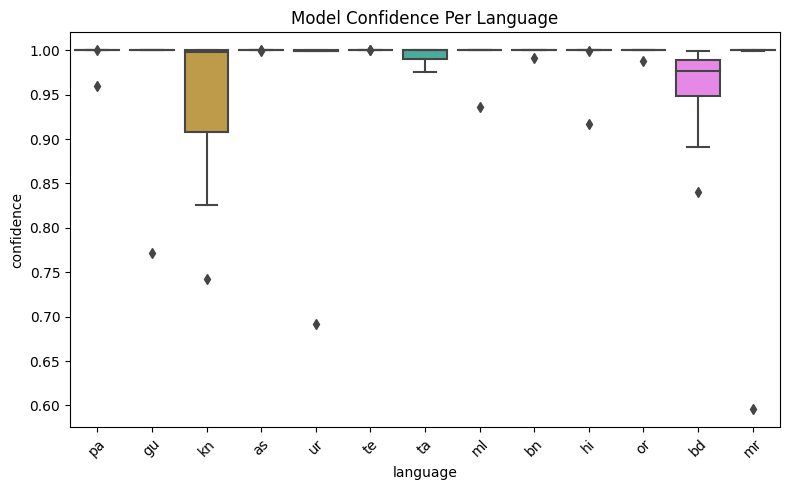

In [56]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_pred,
           x='language',
           y='confidence')
plt.title('Model Confidence Per Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('confidence_per_language.png',
           bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


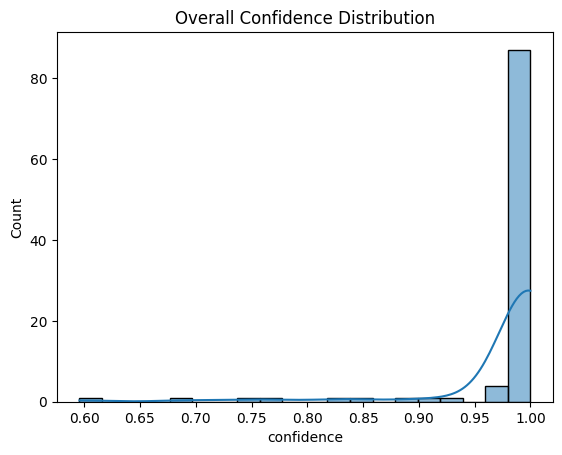

In [58]:
sns.histplot(df_pred["confidence"], bins=20, kde=True)
plt.title("Overall Confidence Distribution")
plt.savefig("confidence_distribution.png", bbox_inches='tight')
plt.show()

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


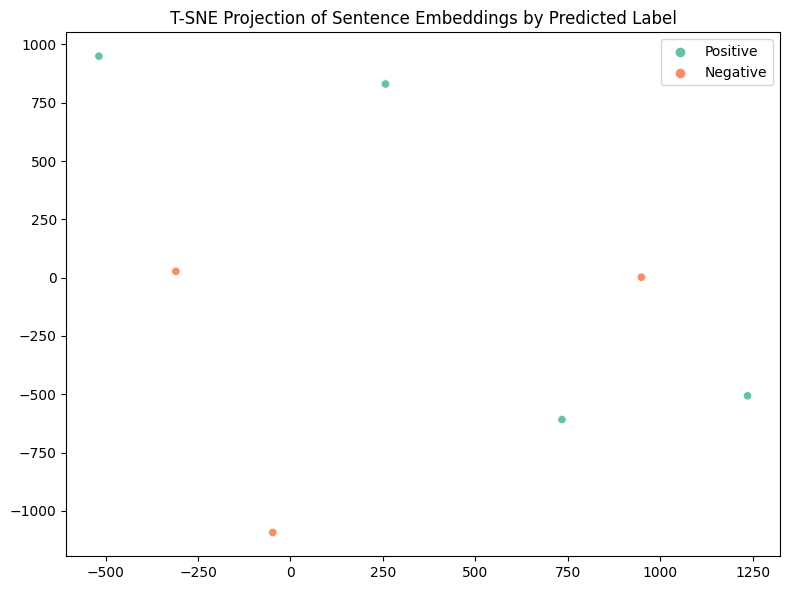

In [61]:
from sklearn.manifold import TSNE
embeddings = []
for example in tqdm(ds_test):
    inputs = tokenizer(example['sentence'],
                      return_tensors='pt',
                      truncation=True,
                      padding=True).to(model.device)
    with torch.no_grad():
        output = model(**inputs,
                      output_hidden_states=True)
        emb = output.hidden_states[-1][:,0,:].cpu().numpy()
        embeddings.append(emb.squeeze())

x = np.array(embeddings)
labels = df_pred['pred_label'].values
tsne = TSNE(n_components=2,
           random_state=42,
           perplexity=30)
x_embedded = tsne.fit_transform(x)

plt.figure(figsize=(8,6))
sns.scatterplot(x=x_embedded[:,0],
               y=x_embedded[:,1],
               hue=labels,
               palette='Set2')
plt.title("T-SNE Projection of Sentence Embeddings by Predicted Label")
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("tsne_embeddings.png",bbox_inches='tight')
plt.show()

In [62]:
!zip -r FTLLAMA.zip /kaggle/working/model

  adding: kaggle/working/model/ (stored 0%)
  adding: kaggle/working/model/README.md (deflated 65%)
  adding: kaggle/working/model/training_args.bin (deflated 52%)
  adding: kaggle/working/model/tokenizer.json (deflated 85%)
  adding: kaggle/working/model/adapter_config.json (deflated 55%)
  adding: kaggle/working/model/special_tokens_map.json (deflated 63%)
  adding: kaggle/working/model/tokenizer_config.json (deflated 94%)
  adding: kaggle/working/model/adapter_model.safetensors (deflated 7%)
